In [58]:
%load_ext autoreload
%autoreload 2

import numpy as np

import scipy

import matplotlib.pyplot as plt
from pathlib import Path
from read_data import get_network_df, get_corrs, get_full_df
from numba.core import types
import graph_tool
import numba

from numba import njit
from graph_tool.topology import shortest_distance
import pandas as pd
import networkx as nx
import graph_tool as gt
from graph_tool.topology import shortest_distance
import numpy as np
import typing

import numba
from numba.core import types

from transport_problem import OptimParams, DualOracle, HyperParams
from subgd import OracleStacker, ustm_mincost_mcf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
graph_type = "SiouxFalls"
print("graph type: ", graph_type)
# SMALL GRAPH:

if graph_type == "SiouxFalls":
    net_df = get_network_df(Path('SiouxFalls') / 'SiouxFalls_net.tntp')
    corrs = get_corrs(Path('SiouxFalls') / 'SiouxFalls_trips.tntp')
    people_count = corrs.sum()
    corrs = corrs / people_count
    net_df.capacity /= people_count
    graph = graph_tool.Graph(net_df.values, eprops=[('capacity', 'double'), ('fft', 'double')])

#BERLING GRAPH
elif graph_type == "Berlin":
    BIG_CONST_FOR_FAKE_EDGES = 400
    net_df = get_network_df(Path('SiouxFalls') / 'berlin-center_net.tntp')
    corrs = get_corrs(Path('SiouxFalls') / 'berlin-center_trips.tntp')
    net_df.loc[net_df.free_flow_time < 1e-6, "free_flow_time"] = BIG_CONST_FOR_FAKE_EDGES
    people_count = corrs.sum()
    corrs = corrs / people_count
    net_df.capacity /= people_count
    net_df = net_df.rename({"free_flow_time":"fft"}, axis=1)

elif graph_type == "Chicago":
    BIG_CONST_FOR_FAKE_EDGES = 40
    net_df = get_network_df(Path('SiouxFalls') / 'ChicagoSketch_net.tntp')
    corrs = get_corrs(Path('SiouxFalls') / 'ChicagoSketch_trips.tntp')
    print(net_df.free_flow_time.max())
    net_df.loc[net_df.free_flow_time < 1e-6, "free_flow_time"] = BIG_CONST_FOR_FAKE_EDGES
    people_count = corrs.sum()
    corrs = corrs / people_count
    net_df.capacity /= people_count
    net_df = net_df.rename({"free_flow_time":"fft"}, axis=1)
    
if graph_type == "Anaheim":
    BIG_CONST_FOR_FAKE_EDGES = 40
    net_df = get_network_df(Path('SiouxFalls') / 'Anaheim_net.tntp')
    corrs = get_corrs(Path('SiouxFalls') / 'Anaheim_trips.tntp')
    print(net_df.free_flow_time.max())
    net_df.loc[net_df.free_flow_time < 1e-6, "free_flow_time"] = BIG_CONST_FOR_FAKE_EDGES
    people_count = corrs.sum()
    corrs = corrs / people_count
    net_df.capacity /= people_count
    net_df = net_df.rename({"free_flow_time":"fft"}, axis=1)
else:
    print("ERROR graph type")

graph type:  SiouxFalls
ERROR graph type


In [94]:
graph = graph_tool.Graph(net_df.values, eprops=[('capacity', 'double'), ('fft', 'double')])

In [95]:
from transport_problem import HyperParams, DualOracle, OptimParams 
l = np.maximum(np.sum(corrs, axis=1), 1e-6)
w = np.maximum(np.sum(corrs, axis=0), 1e-6)

zones_num = len(l)
sources = np.arange(zones_num)
targets = np.arange(zones_num)

params = HyperParams(gamma=10, mu_pow=0.25, rho=0.15)
oracle = DualOracle(graph, l, w, params, net_df=net_df)
oracle_stacker = OracleStacker(oracle, graph, sources, targets)

# oracle.COUNT_PROCESSES = 6

In [131]:

import time 

t1 = time.time()
results = ustm_mincost_mcf(oracle_stacker,  eps_abs=1e-4, eps_cons_abs=1e-4, max_iter=5000, stop_by_crit=True)
t2 = time.time()
print(t2 - t1)

first exceeding the limits:  0.16041110063971112
start optimizing
first dual_func:  11.621762504548435


100%|██████████| 5000/5000 [00:33<00:00, 150.76it/s]

33.16790056228638


In [98]:
# import pandas as pd

# data = []

# for i, j, k in zip(x[1:], np.abs(results.history_dual_gap)[1:], np.abs(results.history_la_mu_grad_norm)[1:]):
#     data.append((i, j, k))

# df = pd.DataFrame(data)
# df.to_csv("plot_ustm.csv", index=False)

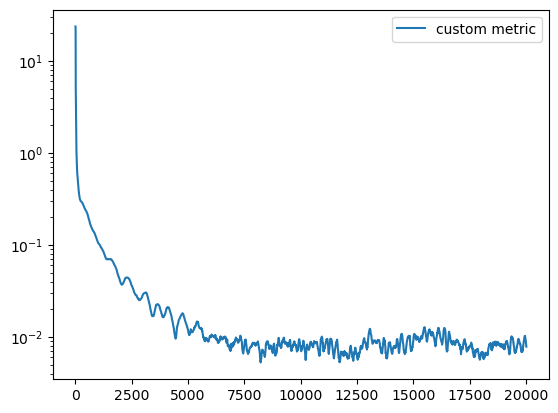

In [132]:
x = results.history_count_calls
dual_gap = results.history_dual_gap
dual_gap_clipped = np.maximum(0, dual_gap)
la_mu_end_norm = np.linalg.norm(np.hstack([oracle_stacker.optim_params.la, oracle_stacker.optim_params.mu]))               
metric = 2 * np.array(results.history_la_mu_grad_norm) * la_mu_end_norm + dual_gap_clipped

plt.plot(x, metric, label="custom metric")
plt.yscale("log")
plt.legend()
plt.show()

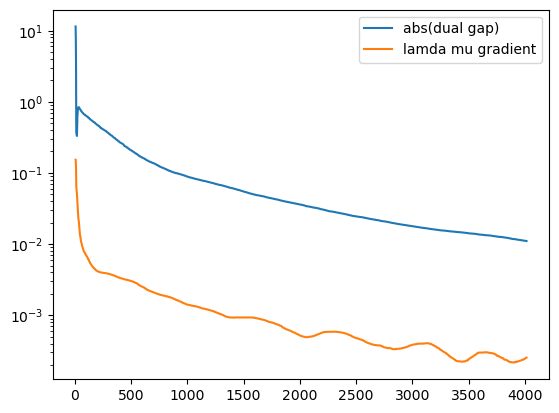

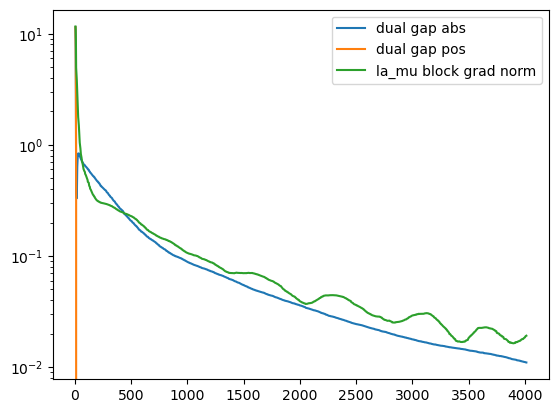

In [118]:

plt.plot(x[1:], np.abs(results.history_dual_gap)[1:],  label="abs(dual gap)")
plt.plot(x[1:], np.abs(results.history_la_mu_grad_norm)[1:],  label="lamda mu gradient")

plt.savefig("plot_ustm_dual_gap abs.png")
plt.yscale("log")
plt.legend()
plt.show()

plt.plot(x[1:], np.abs(results.history_dual_gap)[1:],  label="dual gap abs")
plt.plot(x[1:], results.history_dual_gap[1:],  label="dual gap pos")
plt.plot(x[1:], )), label="la_mu block grad norm")
plt.savefig("plot_ustm_dual_gap.png")
plt.yscale("log")
plt.legend()
plt.show()

# plt.savefig("plot_ustm_la_mu_grad_norm.png")
# plt.yscale("log")
# plt.legend()
# plt.show()


# plt.plot(x, results.history_prime_values, label="history prime function")
# plt.legend()
# plt.show()

# plt.plot(x, results.history_dual_values, label="history dual function")
# plt.legend()
# plt.show()



In [ ]:
# расчет прямой функции
vars = np.zeros(oracle_stacker.parameters_vector_size)  # dual costs w
_ = oracle_stacker(vars)
print("prime function value: ", oracle_stacker.get_prime_value())